
Beale: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Beale'
n_test = 500
eps = 1e-08

util_gp = 'ERM_gp'
util_stp = 'ERM_stp'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Beale(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
       
# Constraints:
lb = -4.5
ub = +4.5

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_lb = 0 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds   

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM_stp': self.ERM_stp,
            'ERM_gp': self.ERM_gp,
        }

        self.f = mode_dict[mode]
    
    def ERM_stp(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def ERM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_gp = time.time()
start_gp


1663668646.792428

In [13]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), objfunc, param)
gp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    	    
1  	 [-2.37435633 -0.56506301]	 71.61499686447547	 6.597029498756062	 3.2978783434865053	 3.4035902288027806
2  	 [4.27902821 4.5       ]	 158187.71146813149	 6.597029498756062	 2.802649344689044	 3.303266071903048
3  	 [ 2.96086352 -3.08884203]	 8543.563822192018	 6.597029498756062	 2.7571081298229	 3.3313911644480396
4  	 [-3.30370358 -0.02951185]	 89.98398580456724	 6.597029498756062	 2.9492353574150054	 3.24177157190795
5  	 [-0.72272694  4.16926632]	 2496.6162260805277	 6.597

In [14]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), objfunc, param)
gp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    	    
1  	 [2.84062527 4.5       ]	 70264.9431379411	 8.81624267140378	 2.998538789286882	 3.1022210661615732
2  	 [ 0.27343392 -0.64448675]	 10.66286934440915	 8.81624267140378	 2.2759466180404235	 2.8796376414950493
3  	 [ 4.5        -2.00507963]	 1850.9261121281302	 8.81624267140378	 2.6091589123328074	 3.7331775640540457
4  	 [-2.23881166  3.69109972]	 12301.26143955591	 8.81624267140378	 2.7168619773809533	 3.1565276599271006
5  	 [-3.10575015  0.4508268 ]	 62.2577826628917	 8.816242671403

In [15]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), objfunc, param)
gp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    	    
1  	 [ 2.02688874 -2.18292273]	 541.8172707416593	 41.912714742005974	 2.096364503506925	 2.775323208047297
2  	 [-2.86892567  4.5       ]	 68383.2060136583	 41.912714742005974	 2.5492796131405413	 2.823312625003037
3	 [-0.6226648  0.3550185]	 21.79071382156392	 21.79071382156392	 2.5940919570198315	 2.5940919570198315
4  	 [-0.33264048 -4.08236422]	 673.7438378493614	 21.79071382156392	 2.3646858794298686	 2.4028627589584426
5	 [-0.2061753   0.00508999]	 16.955778508006063	 16

In [16]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

gp_4= dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), objfunc, param)
gp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    	    
1  	 [-1.14982733  4.5       ]	 10603.397098545647	 3.8409856613776237	 2.2295734349716296	 3.1540475618274812
2  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 2.8227944726476055	 2.8126903053853467
3  	 [-4.34279638  0.44848394]	 91.12669018583735	 3.8409856613776237	 2.798579536121982	 2.8381283316587194
4  	 [0.18688889 0.64582025]	 12.83233207704502	 3.8409856613776237	 2.6609186293134983	 2.660959549626435
5  	 [-0.64660517  0.05226364]	 23.546860358285628	 3.840985

In [17]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), objfunc, param)
gp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871542915	 0.311397019260738	 3.235221350975919	 3.3364866041675123
2  	 [3.79323509 4.08267455]	 70009.93922772788	 0.311397019260738	 2.920163841178715	 2.9539271792973527
3  	 [-4.5       -0.2949202]	 146.54263415905643	 0.311397019260738	 2.5466837123945565	 2.785317405778088
4  	 [ 1.73613187 -0.92222102]	 7.560826073967701	 0.311397019260738	 2.530530870469891	 2.6272540732523293
5  	 [ 4.11451485 -0.10747773]	 14.878957187216457	 0.31

In [18]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), objfunc, param)
gp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    	    
1  	 [4.5       1.3205439]	 112.02763582093375	 10.038000709758428	 3.223006977636138	 3.2408672774276694
2  	 [-4.5        -4.17695531]	 118031.88383517302	 10.038000709758428	 3.1413174165864253	 3.578622542246667
3  	 [1.06382501 4.5       ]	 10246.563496677638	 10.038000709758428	 2.923621147442441	 2.9213539769690673
4  	 [-2.97879762  3.45547868]	 14713.577356333539	 10.038000709758428	 2.657923780631045	 3.351722528746432
5  	 [-0.38979381  0.02250729]	 19.594662348

In [19]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), objfunc, param)
gp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    	    
1  	 [0.30444534 2.175782  ]	 44.694850353883496	 2.9676923934097053	 2.1089068638997626	 2.214332945692641
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 3.3751511602050486	 3.73238200217368
3  	 [4.5 4.5]	 174813.36328125	 2.9676923934097053	 3.0976864204271384	 3.4458440060521354
4  	 [ 2.3497627  -2.80773064]	 3071.4431889655943	 2.9676923934097053	 2.6896726915088927	 2.578125511219795
5  	 [-1.46669149  4.3669769 ]	 14537.036444724683	 2.9676923934097053

In [20]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), objfunc, param)
gp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    	    
1  	 [ 3.30030709 -0.40533353]	 10.906578144625676	 1.8693348557707412	 2.552841007231134	 2.9450147720934727
2  	 [-4.42522463  2.59724938]	 5535.695265667181	 1.8693348557707412	 2.5798873743665345	 3.4989477668585858
3  	 [-0.32212611  1.42926201]	 9.544557072351711	 1.8693348557707412	 2.3397197280368403	 2.335474292826843
4  	 [ 2.74362875 -3.64660397]	 19153.78462232288	 1.8693348557707412	 2.7574002609725294	 3.1016046831523285
5  	 [-0.90749151  0.39981549]	 25.32745672

In [21]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 2.5977975500167707	 2.6514612319596913
2  	 [ 3.46076589 -1.88633632]	 774.461562889617	 22.479204656276803	 2.3949070100184984	 2.871191917952304
3  	 [-1.95600364  3.25417297]	 4227.800417674856	 22.479204656276803	 2.3417915802941573	 2.4088676728558034
4	 [0.89265722 0.64926092]	 8.321399259426006	 8.321399259426006	 2.5657297578524636	 2.615454775815249
5  	 [3.41233874 0.93945795]	 9.262664848979483	

In [22]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), objfunc, param)
gp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 2.6146515176100737	 2.592582163600887
2	 [ 0.01162148 -1.54447788]	 13.905165683454896	 13.905165683454896	 2.2866006553367852	 2.301618243112465
3	 [ 3.60165844 -0.04217479]	 7.842614835435269	 7.842614835435269	 2.2515978754541446	 2.7850909593520052
4  	 [ 3.01258524 -0.64521119]	 13.62014312484009	 7.842614835435269	 2.731091695083198	 2.701402304076441
5  	 [-4.5        -0.45131159]	 155.35567094439142	 7.842614835435269

In [23]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), objfunc, param)
gp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    	    
1  	 [ 3.51851691 -3.076227  ]	 11865.850136148398	 2.8907294990196846	 2.6258061093297105	 3.3921326129358236
2  	 [-2.52542843  2.64609896]	 1907.5127549760878	 2.8907294990196846	 2.149709900598486	 3.029393854258873
3  	 [1.65111138 0.8567444 ]	 8.924405612161141	 2.8907294990196846	 2.76448016818195	 2.8910785405268684
4  	 [-2.96288867 -1.80818793]	 650.2698831293418	 2.8907294990196846	 2.3342962501296167	 2.3342962501296167
5  	 [0.37583607 1.66425771]	 27.412540665989

In [24]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), objfunc, param)
gp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    	    
1	 [-2.42439457  1.3891593 ]	 2.4116526218598064	 2.4116526218598064	 3.0750156493090612	 2.880845490499971
2  	 [0.50569986 2.79505746]	 211.4617713087273	 2.4116526218598064	 3.236713376062238	 3.1405544691812453
3  	 [-4.5 -4.5]	 181853.61328125	 2.4116526218598064	 3.183151856697883	 3.117394682786759
4  	 [-2.45393311  0.80919831]	 27.744282415517862	 2.4116526218598064	 2.477063807639531	 2.5711793054785264
5  	 [4.5 4.5]	 174813.36328125	 2.4116526218598064	 2.6505499609541

In [25]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), objfunc, param)
gp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    	    
1	 [0.87647947 0.76620066]	 9.833494400239523	 9.833494400239523	 2.763461550246	 2.7584641379743386
2  	 [-3.51625583 -3.70571814]	 36387.21686967412	 9.833494400239523	 2.839480692232876	 2.8836824006962494
3  	 [-3.82268477  2.60106574]	 4112.359870652412	 9.833494400239523	 2.7118708303879187	 2.8882070886531404
4  	 [-0.32452179 -1.35266965]	 23.129583903638533	 9.833494400239523	 2.693297067803964	 2.688952286514691
5	 [3.59970014 0.5913862 ]	 0.06206315554276746	 0.06206315

In [26]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), objfunc, param)
gp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    	    
1  	 [1.53250016 1.11671435]	 20.13948326146815	 11.367015527968295	 2.8706352933131623	 2.7249784851402086
2  	 [-4.29401928 -0.4119726 ]	 143.1341716117721	 11.367015527968295	 3.354283536778157	 3.4115333621714985
3  	 [4.5        4.09993299]	 100645.86599710982	 11.367015527968295	 2.7937744936511666	 2.751689228339941
4  	 [-3.29382121 -4.5       ]	 97802.64298148586	 11.367015527968295	 2.8584025217435927	 2.912966587583327
5  	 [ 4.19389567 -0.6362805 ]	 35.8342215156586

In [27]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), objfunc, param)
gp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1  	 [-4.5         0.10959261]	 125.84224810265721	 47.082686538130915	 2.8032639754635253	 2.8157699081678524
2  	 [1.0386015  4.23847861]	 6925.881538672311	 47.082686538130915	 2.7675576907194834	 2.9368511978862246
3  	 [-3.53556367  4.09869646]	 59265.97796332804	 47.082686538130915	 2.9314724050083862	 3.042588965964796
4  	 [4.5       1.4133645]	 173.9964511481253	 47.082686538130915	 2.5058427977268947	 2.5354301924738065
5  	 [4.5 4.5]	 174813.36328125	 47.08268653813

In [28]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), objfunc, param)
gp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    	    
1  	 [3.10451809 4.5       ]	 83759.28100779063	 59.442894178636664	 2.9205052475364197	 2.8967627816938912
2	 [ 4.5        -0.05116121]	 18.96187659301244	 18.96187659301244	 2.7699572826640524	 2.7710617517370038
3	 [ 1.13760564 -0.03938479]	 3.5543488872433397	 3.5543488872433397	 2.555113532016537	 2.555113532016537
4  	 [-4.5 -4.5]	 181853.61328125	 3.5543488872433397	 2.8109909144756626	 2.7282434544846224
5  	 [0.22025152 0.78658601]	 13.112685319486861	 3.554348887243

In [29]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), objfunc, param)
gp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    	    
1  	 [ 4.35944118 -3.9086897 ]	 73233.21388237538	 6.891623366037299	 2.940589188202466	 3.5552887153799113
2  	 [-1.01137564  4.5       ]	 8137.370382178279	 6.891623366037299	 2.6544356854713698	 2.7032627022515823
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 2.616223172851188	 2.6083242536615545
4	 [2.66729317 0.31194837]	 0.13875864455600553	 0.13875864455600553	 2.8013908550113173	 2.8122476911715424
5  	 [2.95003922 0.22334474]	 1.016983879280688	 0.13875864455600553	 2.41

In [30]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), objfunc, param)
gp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    	    
1  	 [-4.5         1.89837954]	 655.9662187694001	 2.472652645883837	 2.71250571397205	 2.8408449245778034
2  	 [-0.2146781   0.24501381]	 16.819632183495493	 2.472652645883837	 2.3426100972297204	 2.3399891997212423
3  	 [ 0.56108525 -0.04086563]	 7.954214709285399	 2.472652645883837	 2.401927788570838	 2.4037346506660078
4  	 [-1.69126185  0.35787451]	 38.527410638718635	 2.472652645883837	 2.7281789472766294	 2.749876002713762
5  	 [-0.05787514  0.37788318]	 14.828593431975197	 2.4

In [31]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), objfunc, param)
gp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    	    
1  	 [ 4.07353862 -3.4478513 ]	 30809.944231909627	 63.544086067314716	 2.8239664078590048	 3.4814812098695986
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 2.758819914076914	 2.758819914076914
3	 [0.22919318 0.51697962]	 12.157760687468183	 12.157760687468183	 2.2162167579249594	 2.2162167579249594
4  	 [ 0.00313462 -0.05150279]	 14.16273986927354	 12.157760687468183	 2.6341337356493195	 2.6424513866076746
5	 [2.88938771 0.75758331]	 2.661423500629234	 2.661423500629234	

In [32]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), objfunc, param)
gp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    	    
1	 [0.122115   0.01132059]	 12.694773939546916	 12.694773939546916	 1.9174222796820688	 1.9174222796820688
2  	 [-4.5 -4.5]	 181853.61328125	 12.694773939546916	 2.892435401186829	 2.886054385426392
3  	 [-2.05277526  4.11642488]	 20137.758854356038	 12.694773939546916	 2.44188999320172	 2.44188999320172
4  	 [ 4.06603407 -2.50992755]	 5050.284622909643	 12.694773939546916	 2.661010835851499	 2.661010835851499
5  	 [-1.02146841 -0.9112768 ]	 37.322051987203025	 12.694773939546916	 2.

In [33]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663668894.6396346

In [34]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), objfunc, param)
stp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    	    
1  	 [-3.47064874  0.91408762]	 23.057022584053712	 6.597029498756062	 3.136268757436948	 3.7040045557843766
2  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 2.605839224936333	 3.230923629193055
3  	 [ 2.96097008 -3.08873547]	 8542.495900953225	 6.597029498756062	 2.814065444213257	 3.9558405122389826
4  	 [-3.79576374  4.5       ]	 120392.80724875955	 6.597029498756062	 3.014356491204784	 3.5919394708673136
5	 [2.38303332 0.54681435]	 0.9111772538217291	 0.9111772538217291	 2.

In [35]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), objfunc, param)
stp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 3.587298160338604	 3.8885448587966174
2  	 [ 4.5        -2.05730438]	 2118.206585339626	 8.81624267140378	 3.171940960035811	 4.135603591868468
3  	 [-0.62138596  3.70983955]	 843.4403240933992	 8.81624267140378	 3.1106294617078074	 3.982683165269566
4  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 2.247443169385562	 3.7582409449102645
5	 [3.06959032 0.52700162]	 0.003418842949696566	 0.003418842949696566	 2.193213559136727	 3.3082337

In [36]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), objfunc, param)
stp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    	    
1  	 [ 2.52283288 -1.74272821]	 259.55509339560894	 41.912714742005974	 2.6373613278713	 2.8202933052884016
2  	 [-3.83738698  3.53153869]	 28235.98177764287	 41.912714742005974	 3.0334719627119244	 3.9165236273827637
3	 [ 1.67951869e-03 -1.69721800e+00]	 14.151950723263168	 14.151950723263168	 3.351291575402958	 3.9757154043379206
4  	 [-0.18976093 -3.93948468]	 214.03278005054008	 14.151950723263168	 2.815953907655124	 4.040760096386735
5  	 [ 2.9558873  -4.12137429]	 45591.6

In [37]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), objfunc, param)
stp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 3.4260813613333823	 4.064205649659845
2  	 [-1.53680621  4.31152515]	 14790.411714068214	 3.8409856613776237	 2.5899187675078403	 3.6051226964364824
3  	 [0.96244795 0.68132543]	 8.300718723669586	 3.8409856613776237	 2.941467468667964	 3.6477786678115156
4  	 [4.5 4.5]	 174813.36328125	 3.8409856613776237	 2.7791152894748894	 4.0076528377711
5  	 [-4.5         1.47837304]	 64.92641102143783	 3.8409856613776237	 2.22357440

In [38]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), objfunc, param)
stp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    	    
1  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 3.880337994280014	 4.2129545740778775
2  	 [ 3.99079899 -3.4958299 ]	 32018.175483599254	 0.311397019260738	 3.5213165968177824	 3.876385928930041
3  	 [-4.5 -4.5]	 181853.61328125	 0.311397019260738	 3.384317820805027	 3.7303963058908205
4  	 [-3.92616179 -0.04253936]	 112.26258763962048	 0.311397019260738	 2.2811890360088367	 3.2657279052571195
5  	 [0.82447422 3.379515  ]	 1260.0692206749895	 0.311397019260738	 2.16792468996187

In [39]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), objfunc, param)
stp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    	    
1  	 [2.4379287  2.38275885]	 1310.2537203284783	 10.038000709758428	 3.7558024707210764	 3.9896506328452674
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 4.477867257689836	 4.241707750652723
3  	 [-2.59935287  4.5       ]	 55999.24147978855	 10.038000709758428	 2.813053930277084	 3.7232574843973243
4  	 [4.5 4.5]	 174813.36328125	 10.038000709758428	 3.2088055382858705	 3.571197683451632
5  	 [-0.75563149 -3.02720534]	 628.5684944378844	 10.038000709758428	 2.012

In [40]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), objfunc, param)
stp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    	    
1  	 [1.80145935 4.13523008]	 17465.710844773588	 2.9676923934097053	 3.5046826158446387	 3.8343908453362485
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 4.267290628343787	 3.9027981774755287
3  	 [ 4.01895261 -3.6195648 ]	 39735.237508657374	 2.9676923934097053	 2.6117878178487453	 3.992313054557519
4  	 [-3.5381093  -1.17462676]	 226.89781537510947	 2.9676923934097053	 2.6774220322818225	 2.677569442883476
5  	 [ 1.10036326 -0.46986737]	 3.9425138694283888

In [41]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), objfunc, param)
stp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    	    
1  	 [ 4.36276653 -4.24138997]	 118257.51382369526	 1.8693348557707412	 2.8442082631668684	 4.111033786088526
2  	 [-4.42522463  2.59724938]	 5535.695265667181	 1.8693348557707412	 2.983464603258856	 3.9590126541927932
3  	 [-1.01857672  4.30650923]	 6286.182417518976	 1.8693348557707412	 2.8438119261809525	 3.675204654249396
4  	 [-2.89284922 -0.65720193]	 94.95624150999117	 1.8693348557707412	 3.3321340000684816	 3.869071470471883
5  	 [-1.81354354  1.68743579]	 19.5532598782

In [42]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 2.3800532542022066	 2.6980687980269895
2  	 [-2.48306887  3.53043911]	 11558.498195861772	 22.479204656276803	 2.6852999120160783	 3.8631446302654835
3  	 [ 4.11875506 -3.13162794]	 18106.252299149455	 22.479204656276803	 3.1056049096692977	 4.1568272477384625
4	 [0.64122612 0.38735022]	 8.217362249345054	 8.217362249345054	 3.6396850103683813	 2.979618946736122
5	 [4.36955627 0.64439412]	 0.42702490886190

In [43]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), objfunc, param)
stp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 2.909996245531442	 3.6313845287076787
2  	 [ 4.5        -0.23788043]	 24.29656213481816	 15.229523981513257	 2.3417560179788732	 3.3238913094677565
3	 [ 1.73287175 -0.47524411]	 2.4400038166606737	 2.4400038166606737	 2.3280184179481855	 3.6193318621656196
4  	 [-0.96150291 -0.008385  ]	 29.275075772477805	 2.4400038166606737	 2.7806649376888974	 3.647779629125201
5  	 [-4.5        -0.06260207]	 135.56596126788318	 2.44000381

In [44]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), objfunc, param)
stp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    	    
1  	 [ 3.37087964 -3.22386427]	 14238.39777012734	 2.8907294990196846	 2.723999950131864	 4.155631722497872
2  	 [-2.76283728  2.40869011]	 1230.7881810804965	 2.8907294990196846	 1.9990436341156474	 3.5115758000626225
3  	 [0.28356989 4.5       ]	 859.8471512261841	 2.8907294990196846	 2.619837253532061	 3.444458025801818
4	 [1.8354214  0.10859602]	 0.8359668767202896	 0.8359668767202896	 2.4713538409009614	 3.3654337560325245
5  	 [ 0.42129943 -2.32592413]	 26.47933987900717

In [45]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), objfunc, param)
stp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    	    
1  	 [4.5 4.5]	 174813.36328125	 48.45196617039589	 3.7112251900295616	 3.392154672672606
2	 [0.3638476  2.00800877]	 41.84217349319556	 41.84217349319556	 3.3003256713448286	 2.822382098244549
3  	 [-4.5 -4.5]	 181853.61328125	 41.84217349319556	 3.1669179688798663	 3.2400819168962816
4	 [-0.21879947 -2.21445007]	 34.04918797856735	 34.04918797856735	 2.112244566919425	 2.098964278602236
5	 [2.82520411 0.17767102]	 0.9479404731251339	 0.9479404731251339	 2.2223380770413064	 2.543

In [46]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), objfunc, param)
stp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    	    
1  	 [-1.3620619   0.56042914]	 28.58652179798336	 25.917758071459016	 3.282293957041925	 2.8362337599680076
2  	 [-4.5 -4.5]	 181853.61328125	 25.917758071459016	 2.9961625222568036	 3.789598165454842
3  	 [-2.3739109   4.04983962]	 24521.854857021743	 25.917758071459016	 2.6775631968882077	 3.5065432798255456
4  	 [-0.99121904 -2.00315788]	 154.76321179041608	 25.917758071459016	 2.6321209733597333	 3.4846456860498
5  	 [-4.35456867  0.17918457]	 115.9068608126963	 25.9177580714

In [47]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), objfunc, param)
stp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    	    
1  	 [3.02114695 2.14578923]	 1064.7464748913296	 11.367015527968295	 3.4435364426803288	 3.4805081088207905
2  	 [-2.7042976  -4.43938819]	 61131.93409576092	 11.367015527968295	 4.0456554287109	 3.908575127186448
3  	 [-4.08785431  0.19115862]	 106.07884345821006	 11.367015527968295	 3.2313555114716674	 3.507851254441235
4  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 2.122871773637881	 3.7560917480931915
5  	 [ 4.24394386 -0.25925689]	 20.56352008727636	 11.367015527968

In [48]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), objfunc, param)
stp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.2231993   1.25540485]	 2.484096500444409	 2.484096500444409	 3.4019447496601622	 3.932382036667184
2  	 [4.5 4.5]	 174813.36328125	 2.484096500444409	 2.7204117899479927	 3.6235814674452294
3  	 [-1.50884704  4.5       ]	 18517.13081168743	 2.484096500444409	 3.1422987850665107	 3.602090456499991
4  	 [1.00653116 1.05051533]	 15.705947284777894	 2.484096500444409	 2.917317485455993	 3.501544385228378
5  	 [-0.87742491 -3.95633549]	 3492.0144638539	 2.484096500444409	 2.

In [49]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), objfunc, param)
stp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 4.035917866347818	 4.058336365264469
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 3.4633051379895483	 3.392246761846429
3	 [0.40633477 1.79762317]	 34.25975673538963	 34.25975673538963	 2.3796321688392696	 2.750719686181205
4	 [ 3.89010981 -0.13096572]	 12.505803713943388	 12.505803713943388	 2.357562257028644	 3.570028443584319
5	 [ 1.08269732 -0.46423035]	 4.025363473461972	 4.025363473461972	 1.9210674818906743

In [50]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), objfunc, param)
stp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    	    
1  	 [ 4.35945178 -3.9086791 ]	 73232.4143310993	 6.891623366037299	 2.6989897375605354	 4.275542575222288
2  	 [-0.85775711  4.5       ]	 5782.8121791438425	 6.891623366037299	 2.573651005124183	 3.659207144759502
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 3.0184494889635625	 3.541895103157955
4  	 [-3.26020916  2.40465371]	 1743.5131005326175	 6.891623366037299	 3.1964278579971044	 3.632651547286546
5  	 [ 0.33581831 -1.74184714]	 9.203037724799993	 6.891623366037299	 2.8666

In [51]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), objfunc, param)
stp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    	    
1  	 [-4.40092736  2.56404717]	 5035.96011064499	 2.472652645883837	 3.282949780319489	 4.053218197663953
2  	 [-1.35457812  0.02977407]	 36.74107050916032	 2.472652645883837	 3.3912152402780698	 3.526406167747907
3  	 [4.5 4.5]	 174813.36328125	 2.472652645883837	 3.3393905660767866	 4.207154438587903
4  	 [-4.14434242 -0.88726269]	 190.09249673795992	 2.472652645883837	 2.656597375451357	 3.765355142225287
5  	 [3.62573451 0.1751258 ]	 4.784335726556383	 2.472652645883837	 2.9348853

In [52]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), objfunc, param)
stp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    	    
1  	 [ 4.24144768 -3.27994224]	 25066.90388973683	 63.544086067314716	 3.226839509690986	 4.287686750313873
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 3.007015252536517	 4.0639513907883815
3	 [ 0.72389237 -0.4713087 ]	 6.366618941918231	 6.366618941918231	 2.6069861892929147	 2.996086483799383
4  	 [-1.09589222  4.3636585 ]	 7939.628140900609	 6.366618941918231	 3.002047424690258	 3.291416754678514
5	 [-1.30551489  1.23526488]	 6.0276059683994365	 6.0276059683994365	 2

In [53]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), objfunc, param)
stp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 3.432462306815486	 3.8668700907619624
2  	 [ 3.86001923 -0.86784666]	 48.4086812354221	 30.55204392634667	 2.870902438158627	 3.684254238405863
3  	 [-2.15425903  3.89588229]	 15854.899385477474	 30.55204392634667	 2.831554135702942	 4.220754651787456
4  	 [-1.1442791  -2.28105711]	 335.20265897404863	 30.55204392634667	 2.8440756162188614	 4.290052655909201
5	 [1.42663194 0.36707909]	 2.998114713686749	 2.998114713686749	 2.96127

In [54]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp


920.2431421279907

In [55]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.min(-gp_1.GP.y[0:n_init]),-gp_1.GP.y[n_init:(n_init+iters)]) 
stp_output_1 = np.append(np.min(-stp_1.GP.y[0:n_init]),-stp_1.GP.y[n_init:(n_init+iters)]) 

regret_gp_1 = np.log(gp_output_1 - y_global_orig)
regret_stp_1 = np.log(stp_output_1 - y_global_orig)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-1.1218168425520572, -0.09301783004295386)

In [56]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.min(-gp_2.GP.y[0:n_init]),-gp_2.GP.y[n_init:(n_init+iters)]) 
stp_output_2 = np.append(np.min(-stp_2.GP.y[0:n_init]),-stp_2.GP.y[n_init:(n_init+iters)]) 

regret_gp_2 = np.log(gp_output_2 - y_global_orig)
regret_stp_2 = np.log(stp_output_2 - y_global_orig)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(1.009007149132472, -5.678453103952514)

In [57]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.min(-gp_3.GP.y[0:n_init]),-gp_3.GP.y[n_init:(n_init+iters)]) 
stp_output_3 = np.append(np.min(-stp_3.GP.y[0:n_init]),-stp_3.GP.y[n_init:(n_init+iters)]) 

regret_gp_3 = np.log(gp_output_3 - y_global_orig)
regret_stp_3 = np.log(stp_output_3 - y_global_orig)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3

(0.060447131196057984, 0.8494437855111835)

In [58]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.min(-gp_4.GP.y[0:n_init]),-gp_4.GP.y[n_init:(n_init+iters)]) 
stp_output_4 = np.append(np.min(-stp_4.GP.y[0:n_init]),-stp_4.GP.y[n_init:(n_init+iters)]) 

regret_gp_4 = np.log(gp_output_4 - y_global_orig)
regret_stp_4 = np.log(stp_output_4 - y_global_orig)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4

(-2.1266463442484316, 1.060445558093623)

In [59]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.min(-gp_5.GP.y[0:n_init]),-gp_5.GP.y[n_init:(n_init+iters)]) 
stp_output_5 = np.append(np.min(-stp_5.GP.y[0:n_init]),-stp_5.GP.y[n_init:(n_init+iters)]) 

regret_gp_5 = np.log(gp_output_5 - y_global_orig)
regret_stp_5 = np.log(stp_output_5 - y_global_orig)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5

(-2.249974812327161, -1.1666865916873388)

In [60]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.min(-gp_6.GP.y[0:n_init]),-gp_6.GP.y[n_init:(n_init+iters)]) 
stp_output_6 = np.append(np.min(-stp_6.GP.y[0:n_init]),-stp_6.GP.y[n_init:(n_init+iters)]) 

regret_gp_6 = np.log(gp_output_6 - y_global_orig)
regret_stp_6 = np.log(stp_output_6 - y_global_orig)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6

(-0.9525377913732019, -1.7007766071513328)

In [61]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.min(-gp_7.GP.y[0:n_init]),-gp_7.GP.y[n_init:(n_init+iters)]) 
stp_output_7 = np.append(np.min(-stp_7.GP.y[0:n_init]),-stp_7.GP.y[n_init:(n_init+iters)]) 

regret_gp_7 = np.log(gp_output_7 - y_global_orig)
regret_stp_7 = np.log(stp_output_7 - y_global_orig)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7

(1.087784678899565, 0.7339903581714671)

In [62]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.min(-gp_8.GP.y[0:n_init]),-gp_8.GP.y[n_init:(n_init+iters)]) 
stp_output_8 = np.append(np.min(-stp_8.GP.y[0:n_init]),-stp_8.GP.y[n_init:(n_init+iters)]) 

regret_gp_8 = np.log(gp_output_8 - y_global_orig)
regret_stp_8 = np.log(stp_output_8 - y_global_orig)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8

(-0.6198746338920682, 0.6255826754918475)

In [63]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.min(-gp_9.GP.y[0:n_init]),-gp_9.GP.y[n_init:(n_init+iters)]) 
stp_output_9 = np.append(np.min(-stp_9.GP.y[0:n_init]),-stp_9.GP.y[n_init:(n_init+iters)]) 

regret_gp_9 = np.log(gp_output_9 - y_global_orig)
regret_stp_9 = np.log(stp_output_9 - y_global_orig)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9

(-1.1128260282170568, -0.8509129328837026)

In [64]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.min(-gp_10.GP.y[0:n_init]),-gp_10.GP.y[n_init:(n_init+iters)]) 
stp_output_10 = np.append(np.min(-stp_10.GP.y[0:n_init]),-stp_10.GP.y[n_init:(n_init+iters)]) 

regret_gp_10 = np.log(gp_output_10 - y_global_orig)
regret_stp_10 = np.log(stp_output_10 - y_global_orig)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10

(-0.286736149078743, -5.066001495808999)

In [65]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.min(-gp_11.GP.y[0:n_init]),-gp_11.GP.y[n_init:(n_init+iters)]) 
stp_output_11 = np.append(np.min(-stp_11.GP.y[0:n_init]),-stp_11.GP.y[n_init:(n_init+iters)]) 

regret_gp_11 = np.log(gp_output_11 - y_global_orig)
regret_stp_11 = np.log(stp_output_11 - y_global_orig)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11

(-0.08867755686795122, -0.17916628783035282)

In [66]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.min(-gp_12.GP.y[0:n_init]),-gp_12.GP.y[n_init:(n_init+iters)]) 
stp_output_12 = np.append(np.min(-stp_12.GP.y[0:n_init]),-stp_12.GP.y[n_init:(n_init+iters)]) 

regret_gp_12 = np.log(gp_output_12 - y_global_orig)
regret_stp_12 = np.log(stp_output_12 - y_global_orig)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12

(-0.8352418952087651, -0.0534635707607144)

In [67]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.min(-gp_13.GP.y[0:n_init]),-gp_13.GP.y[n_init:(n_init+iters)]) 
stp_output_13 = np.append(np.min(-stp_13.GP.y[0:n_init]),-stp_13.GP.y[n_init:(n_init+iters)]) 

regret_gp_13 = np.log(gp_output_13 - y_global_orig)
regret_stp_13 = np.log(stp_output_13 - y_global_orig)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13

(-2.779602774609892, 0.8706635999701741)

In [68]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.min(-gp_14.GP.y[0:n_init]),-gp_14.GP.y[n_init:(n_init+iters)]) 
stp_output_14 = np.append(np.min(-stp_14.GP.y[0:n_init]),-stp_14.GP.y[n_init:(n_init+iters)]) 

regret_gp_14 = np.log(gp_output_14 - y_global_orig)
regret_stp_14 = np.log(stp_output_14 - y_global_orig)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14

(-0.2684836831910447, 0.44227856576147623)

In [69]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.min(-gp_15.GP.y[0:n_init]),-gp_15.GP.y[n_init:(n_init+iters)]) 
stp_output_15 = np.append(np.min(-stp_15.GP.y[0:n_init]),-stp_15.GP.y[n_init:(n_init+iters)]) 

regret_gp_15 = np.log(gp_output_15 - y_global_orig)
regret_stp_15 = np.log(stp_output_15 - y_global_orig)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15

(-2.861383860654811, 0.5616188453131084)

In [70]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.min(-gp_16.GP.y[0:n_init]),-gp_16.GP.y[n_init:(n_init+iters)]) 
stp_output_16 = np.append(np.min(-stp_16.GP.y[0:n_init]),-stp_16.GP.y[n_init:(n_init+iters)]) 

regret_gp_16 = np.log(gp_output_16 - y_global_orig)
regret_stp_16 = np.log(stp_output_16 - y_global_orig)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16

(-2.0372539576375495, 1.0499775075531752)

In [71]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.min(-gp_17.GP.y[0:n_init]),-gp_17.GP.y[n_init:(n_init+iters)]) 
stp_output_17 = np.append(np.min(-stp_17.GP.y[0:n_init]),-stp_17.GP.y[n_init:(n_init+iters)]) 

regret_gp_17 = np.log(gp_output_17 - y_global_orig)
regret_stp_17 = np.log(stp_output_17 - y_global_orig)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17

(-2.9522171923829763, 1.9303066691801607)

In [72]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.min(-gp_18.GP.y[0:n_init]),-gp_18.GP.y[n_init:(n_init+iters)]) 
stp_output_18 = np.append(np.min(-stp_18.GP.y[0:n_init]),-stp_18.GP.y[n_init:(n_init+iters)]) 

regret_gp_18 = np.log(gp_output_18 - y_global_orig)
regret_stp_18 = np.log(stp_output_18 - y_global_orig)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18

(0.5694998544240025, 0.9052915200747084)

In [73]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.min(-gp_19.GP.y[0:n_init]),-gp_19.GP.y[n_init:(n_init+iters)]) 
stp_output_19 = np.append(np.min(-stp_19.GP.y[0:n_init]),-stp_19.GP.y[n_init:(n_init+iters)]) 

regret_gp_19 = np.log(gp_output_19 - y_global_orig)
regret_stp_19 = np.log(stp_output_19 - y_global_orig)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19

(-2.4415339139202192, 1.7963499117397908)

In [74]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.min(-gp_20.GP.y[0:n_init]),-gp_20.GP.y[n_init:(n_init+iters)]) 
stp_output_20 = np.append(np.min(-stp_20.GP.y[0:n_init]),-stp_20.GP.y[n_init:(n_init+iters)]) 

regret_gp_20 = np.log(gp_output_20 - y_global_orig)
regret_stp_20 = np.log(stp_output_20 - y_global_orig)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20

(0.9239202918848277, 0.8774213136816972)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

exact1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp1 = np.asarray(approx1_results[4:5][0])[0]
median_gp1 = np.asarray(approx1_results[9:10][0])[0]
upper_gp1 = np.asarray(approx1_results[14:15][0])[0]

lower_stp1 = np.asarray(exact1_results[4:5][0])[0]
median_stp1 = np.asarray(exact1_results[9:10][0])[0]
upper_stp1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

exact11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp11 = np.asarray(approx11_results[4:5][0])[0]
median_gp11 = np.asarray(approx11_results[9:10][0])[0]
upper_gp11 = np.asarray(approx11_results[14:15][0])[0]

lower_stp11 = np.asarray(exact11_results[4:5][0])[0]
median_stp11 = np.asarray(exact11_results[9:10][0])[0]
upper_stp11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

exact21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp21 = np.asarray(approx21_results[4:5][0])[0]
median_gp21 = np.asarray(approx21_results[9:10][0])[0]
upper_gp21 = np.asarray(approx21_results[14:15][0])[0]

lower_stp21 = np.asarray(exact21_results[4:5][0])[0]
median_stp21 = np.asarray(exact21_results[9:10][0])[0]
upper_stp21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

exact2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp2 = np.asarray(approx2_results[4:5][0])[0]
median_gp2 = np.asarray(approx2_results[9:10][0])[0]
upper_gp2 = np.asarray(approx2_results[14:15][0])[0]

lower_stp2 = np.asarray(exact2_results[4:5][0])[0]
median_stp2 = np.asarray(exact2_results[9:10][0])[0]
upper_stp2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

exact12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp12 = np.asarray(approx12_results[4:5][0])[0]
median_gp12 = np.asarray(approx12_results[9:10][0])[0]
upper_gp12 = np.asarray(approx12_results[14:15][0])[0]

lower_stp12 = np.asarray(exact12_results[4:5][0])[0]
median_stp12 = np.asarray(exact12_results[9:10][0])[0]
upper_stp12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

exact3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp3 = np.asarray(approx3_results[4:5][0])[0]
median_gp3 = np.asarray(approx3_results[9:10][0])[0]
upper_gp3 = np.asarray(approx3_results[14:15][0])[0]

lower_stp3 = np.asarray(exact3_results[4:5][0])[0]
median_stp3 = np.asarray(exact3_results[9:10][0])[0]
upper_stp3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

exact13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp13 = np.asarray(approx13_results[4:5][0])[0]
median_gp13 = np.asarray(approx13_results[9:10][0])[0]
upper_gp13 = np.asarray(approx13_results[14:15][0])[0]

lower_stp13 = np.asarray(exact13_results[4:5][0])[0]
median_stp13 = np.asarray(exact13_results[9:10][0])[0]
upper_stp13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

exact4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp4 = np.asarray(approx4_results[4:5][0])[0]
median_gp4 = np.asarray(approx4_results[9:10][0])[0]
upper_gp4 = np.asarray(approx4_results[14:15][0])[0]

lower_stp4 = np.asarray(exact4_results[4:5][0])[0]
median_stp4 = np.asarray(exact4_results[9:10][0])[0]
upper_stp4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

exact14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp14 = np.asarray(approx14_results[4:5][0])[0]
median_gp14 = np.asarray(approx14_results[9:10][0])[0]
upper_gp14 = np.asarray(approx14_results[14:15][0])[0]

lower_stp14 = np.asarray(exact14_results[4:5][0])[0]
median_stp14 = np.asarray(exact14_results[9:10][0])[0]
upper_stp14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

exact5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp5 = np.asarray(approx5_results[4:5][0])[0]
median_gp5 = np.asarray(approx5_results[9:10][0])[0]
upper_gp5 = np.asarray(approx5_results[14:15][0])[0]

lower_stp5 = np.asarray(exact5_results[4:5][0])[0]
median_stp5 = np.asarray(exact5_results[9:10][0])[0]
upper_stp5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

exact15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp15 = np.asarray(approx15_results[4:5][0])[0]
median_gp15 = np.asarray(approx15_results[9:10][0])[0]
upper_gp15 = np.asarray(approx15_results[14:15][0])[0]

lower_stp15 = np.asarray(exact15_results[4:5][0])[0]
median_stp15 = np.asarray(exact15_results[9:10][0])[0]
upper_stp15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

exact6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp6 = np.asarray(approx6_results[4:5][0])[0]
median_gp6 = np.asarray(approx6_results[9:10][0])[0]
upper_gp6 = np.asarray(approx6_results[14:15][0])[0]

lower_stp6 = np.asarray(exact6_results[4:5][0])[0]
median_stp6 = np.asarray(exact6_results[9:10][0])[0]
upper_stp6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

exact16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp16 = np.asarray(approx16_results[4:5][0])[0]
median_gp16 = np.asarray(approx16_results[9:10][0])[0]
upper_gp16 = np.asarray(approx16_results[14:15][0])[0]

lower_stp16 = np.asarray(exact16_results[4:5][0])[0]
median_stp16 = np.asarray(exact16_results[9:10][0])[0]
upper_stp16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

exact7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp7 = np.asarray(approx7_results[4:5][0])[0]
median_gp7 = np.asarray(approx7_results[9:10][0])[0]
upper_gp7 = np.asarray(approx7_results[14:15][0])[0]

lower_stp7 = np.asarray(exact7_results[4:5][0])[0]
median_stp7 = np.asarray(exact7_results[9:10][0])[0]
upper_stp7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

exact17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp17 = np.asarray(approx17_results[4:5][0])[0]
median_gp17 = np.asarray(approx17_results[9:10][0])[0]
upper_gp17 = np.asarray(approx17_results[14:15][0])[0]

lower_stp17 = np.asarray(exact17_results[4:5][0])[0]
median_stp17 = np.asarray(exact17_results[9:10][0])[0]
upper_stp17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

exact8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp8 = np.asarray(approx8_results[4:5][0])[0]
median_gp8 = np.asarray(approx8_results[9:10][0])[0]
upper_gp8 = np.asarray(approx8_results[14:15][0])[0]

lower_stp8 = np.asarray(exact8_results[4:5][0])[0]
median_stp8 = np.asarray(exact8_results[9:10][0])[0]
upper_stp8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

exact18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp18 = np.asarray(approx18_results[4:5][0])[0]
median_gp18 = np.asarray(approx18_results[9:10][0])[0]
upper_gp18 = np.asarray(approx18_results[14:15][0])[0]

lower_stp18 = np.asarray(exact18_results[4:5][0])[0]
median_stp18 = np.asarray(exact18_results[9:10][0])[0]
upper_stp18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

exact9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp9 = np.asarray(approx9_results[4:5][0])[0]
median_gp9 = np.asarray(approx9_results[9:10][0])[0]
upper_gp9 = np.asarray(approx9_results[14:15][0])[0]

lower_stp9 = np.asarray(exact9_results[4:5][0])[0]
median_stp9 = np.asarray(exact9_results[9:10][0])[0]
upper_stp9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

exact19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp19 = np.asarray(approx19_results[4:5][0])[0]
median_gp19 = np.asarray(approx19_results[9:10][0])[0]
upper_gp19 = np.asarray(approx19_results[14:15][0])[0]

lower_stp19 = np.asarray(exact19_results[4:5][0])[0]
median_stp19 = np.asarray(exact19_results[9:10][0])[0]
upper_stp19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

exact10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp10 = np.asarray(approx10_results[4:5][0])[0]
median_gp10 = np.asarray(approx10_results[9:10][0])[0]
upper_gp10 = np.asarray(approx10_results[14:15][0])[0]

lower_stp10 = np.asarray(exact10_results[4:5][0])[0]
median_stp10 = np.asarray(exact10_results[9:10][0])[0]
upper_stp10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

exact20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp20 = np.asarray(approx20_results[4:5][0])[0]
median_gp20 = np.asarray(approx20_results[9:10][0])[0]
upper_gp20 = np.asarray(approx20_results[14:15][0])[0]

lower_stp20 = np.asarray(exact20_results[4:5][0])[0]
median_stp20 = np.asarray(exact20_results[9:10][0])[0]
upper_stp20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]

In [97]:
### Summarize arrays: 'exact'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]

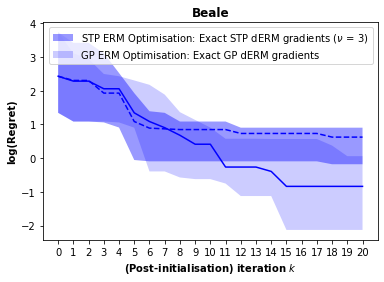

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_stp, color = 'Blue', ls='--')
plt.plot(median_gp, color = 'Blue', ls='-')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Optimisation: Exact STP dERM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Blue', alpha=0.2, label='GP ERM Optimisation: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_gp, time_stp


(247.8470528125763, 920.2431421279907)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncgp_gp_1 = acqFuncExact(gp_1.history)
acqFuncstp_stp_1 = acqFuncExact(stp_1.history)

e1 = np.std(acqFuncstp_stp_1)
a1 = np.std(acqFuncgp_gp_1)

e1, a1


(0.23813480866232167, 0.24827266032064818)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncgp_gp_2 = acqFuncExact(gp_2.history)
acqFuncstp_stp_2 = acqFuncExact(stp_2.history)

e2 = np.std(acqFuncstp_stp_2)
a2 = np.std(acqFuncgp_gp_2)

e2, a2


(0.3848311417367734, 0.19200629913641323)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncgp_gp_3 = acqFuncExact(gp_3.history)
acqFuncstp_stp_3 = acqFuncExact(stp_3.history)

e3 = np.std(acqFuncstp_stp_3)
a3 = np.std(acqFuncgp_gp_3)

e3, a3


(0.37358039482892336, 0.1574263735782186)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncgp_gp_4 = acqFuncExact(gp_4.history)
acqFuncstp_stp_4 = acqFuncExact(stp_4.history)

e4 = np.std(acqFuncstp_stp_4)
a4 = np.std(acqFuncgp_gp_4)

e4, a4


(0.36232626075736485, 0.23823293664387565)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncgp_gp_5 = acqFuncExact(gp_5.history)
acqFuncstp_stp_5 = acqFuncExact(stp_5.history)

e5 = np.std(acqFuncstp_stp_5)
a5 = np.std(acqFuncgp_gp_5)

e5, a5


(0.46933021710751377, 0.2400113373840504)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncgp_gp_6 = acqFuncExact(gp_6.history)
acqFuncstp_stp_6 = acqFuncExact(stp_6.history)

e6 = np.std(acqFuncstp_stp_6)
a6 = np.std(acqFuncgp_gp_6)

e6, a6


(0.5699178182979731, 0.23079633262916596)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncgp_gp_7 = acqFuncExact(gp_7.history)
acqFuncstp_stp_7 = acqFuncExact(stp_7.history)

e7 = np.std(acqFuncstp_stp_7)
a7 = np.std(acqFuncgp_gp_7)

e7, a7


(0.47098091608266424, 0.3024347290033858)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncgp_gp_8 = acqFuncExact(gp_8.history)
acqFuncstp_stp_8 = acqFuncExact(stp_8.history)

e8 = np.std(acqFuncstp_stp_8)
a8 = np.std(acqFuncgp_gp_8)

e8, a8


(0.24643180552371427, 0.16546844331523733)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncgp_gp_9 = acqFuncExact(gp_9.history)
acqFuncstp_stp_9 = acqFuncExact(stp_9.history)

e9 = np.std(acqFuncstp_stp_9)
a9 = np.std(acqFuncgp_gp_9)

e9, a9


(0.33370713595889384, 0.16510729774567526)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncgp_gp_10 = acqFuncExact(gp_10.history)
acqFuncstp_stp_10 = acqFuncExact(stp_10.history)

e10 = np.std(acqFuncstp_stp_10)
a10 = np.std(acqFuncgp_gp_10)

e10, a10


(0.30130990740686836, 0.18662154440902262)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncgp_gp_11 = acqFuncExact(gp_11.history)
acqFuncstp_stp_11 = acqFuncExact(stp_11.history)

e11 = np.std(acqFuncstp_stp_11)
a11 = np.std(acqFuncgp_gp_11)

e11, a11


(0.24006939376060177, 0.18935564495446336)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncgp_gp_12 = acqFuncExact(gp_12.history)
acqFuncstp_stp_12 = acqFuncExact(stp_12.history)

e12 = np.std(acqFuncstp_stp_12)
a12 = np.std(acqFuncgp_gp_12)

e12, a12


(0.40881661923508417, 0.2551143500769471)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncgp_gp_13 = acqFuncExact(gp_13.history)
acqFuncstp_stp_13 = acqFuncExact(stp_13.history)

e13 = np.std(acqFuncstp_stp_13)
a13 = np.std(acqFuncgp_gp_13)

e13, a13


(0.22928662915907505, 0.21241489085275156)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncgp_gp_14 = acqFuncExact(gp_14.history)
acqFuncstp_stp_14 = acqFuncExact(stp_14.history)

e14 = np.std(acqFuncstp_stp_14)
a14 = np.std(acqFuncgp_gp_14)

e14, a14


(0.4260577559011173, 0.2327470674194539)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncgp_gp_15 = acqFuncExact(gp_15.history)
acqFuncstp_stp_15 = acqFuncExact(stp_15.history)

e15 = np.std(acqFuncstp_stp_15)
a15 = np.std(acqFuncgp_gp_15)

e15, a15


(0.4462299533960763, 0.22496680442996153)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncgp_gp_16 = acqFuncExact(gp_16.history)
acqFuncstp_stp_16 = acqFuncExact(stp_16.history)

e16 = np.std(acqFuncstp_stp_16)
a16 = np.std(acqFuncgp_gp_16)

e16, a16


(0.49198691413517015, 0.2157475230258208)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncgp_gp_17 = acqFuncExact(gp_17.history)
acqFuncstp_stp_17 = acqFuncExact(stp_17.history)

e17 = np.std(acqFuncstp_stp_17)
a17 = np.std(acqFuncgp_gp_17)

e17, a17


(0.30323833494381935, 0.20725753440975087)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncgp_gp_18 = acqFuncExact(gp_18.history)
acqFuncstp_stp_18 = acqFuncExact(stp_18.history)

e18 = np.std(acqFuncstp_stp_18)
a18 = np.std(acqFuncgp_gp_18)

e18, a18


(0.4167695805861837, 0.17992285006254988)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncgp_gp_19 = acqFuncExact(gp_19.history)
acqFuncstp_stp_19 = acqFuncExact(stp_19.history)

e19 = np.std(acqFuncstp_stp_19)
a19 = np.std(acqFuncgp_gp_19)

e19, a19


(0.35698596022697165, 0.1933952625825458)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncgp_gp_20 = acqFuncExact(gp_20.history)
acqFuncstp_stp_20 = acqFuncExact(stp_20.history)

e20 = np.std(acqFuncstp_stp_20)
a20 = np.std(acqFuncgp_gp_20)

e20, a20


(0.41124134755970143, 0.25874678171638665)

In [120]:
### Summarize arrays: 

stp_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
gp_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(stp_stddev), np.mean(gp_stddev)


(0.37406164476334053, 0.2148023331848162)

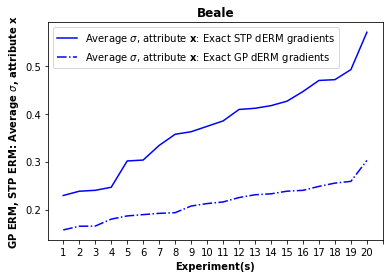

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(stp_stddev, color = 'Blue', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dERM gradients')
plt.plot(gp_stddev, color = 'Blue', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP ERM, STP ERM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
